In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show 
from bokeh.plotting import figure
from bokeh.models import HoverTool,ColumnDataSource

In [14]:
dt_qzvpp=pd.read_pickle('data_def2_qzvpp')
dt_tzvp=pd.read_pickle('data_def2_tzvp')

In [15]:
dt_sto3g=pd.read_pickle("data_sto3G")
dt_sto6g=pd.read_pickle("data_sto6G")

In [16]:
dt_321g=pd.read_pickle("data_321G")
dt_631g=pd.read_pickle("data_631G")

In [17]:
dt_aug=pd.read_pickle("data_aug")
dt_ccpvtz=pd.read_pickle("data_ccpvtz")

In [22]:
proj_path="/home/giorgiod/MRCC_interface/PES-BS-ALCHEMY/"

In [23]:
def parse_energy(log_file,calc):
    calc_str={"hf":"FINAL HARTREE-FOCK ENERGY","ccsd" : "Total CCSD energy", "mp2":"Total MP2 energy [au]" }
    """Parse the hartree Fock energy from an MRCC output file"""
    try:
        with open(log_file,'r') as logf:
            while True:
                line=logf.readline()
                if calc_str[calc] in line:
                    good_line=line
                    for x in good_line.split(' '):
                        try:
                            float(x)
                            return (float(x))
                        except:
                            pass    
    except:
        print('couldn\'t parse energy return 0 for: '+log_file)
        return 0

In [24]:
def dirName(basis_set,molecule,point,alchemy=0):
    return proj_path+basis_set+'/'+molecule+"/A{}_Radius:{}".format(alchemy,str(point)[0:3])+'/'

In [25]:
def energy(bs,mol,pt,calc,al=0):
    return parse_energy(dirName(bs,mol,pt,al)+'run.log',calc)
basisSets=['sto3G', 'sto6G', '321G','631G*','def2-TZVP','def2-QZVPP','cc-pVTZ','aug-cc-pVQZ']
molecules=['HAl','HeMg','LiNa','BeNe','BF','CO','NN']

In [26]:
energy("sto3G","CO",2.4,"mp2")-energy("sto3G","CO",2.4,"ccsd")

-0.006897507429002303

In [27]:
dt_sto3g[:10]

,alchemy,distance,basis_set,e_alch,e_ccsd,ref,target,abs_err,delta_rho,e_at_ref_bs,err_alch,delta_rho_int
0,0,1.3,sto3G,-195.799703,-198.025411,HAl,HeMg,2.225708,3.368281,-196.696725,0.897022,3
1,1,1.3,sto3G,-196.515815,-198.025411,HAl,HeMg,1.509596,3.368281,-196.696725,0.180910,3
2,2,1.3,sto3G,-196.700337,-198.025411,HAl,HeMg,1.325074,3.368281,-196.696725,0.003611,3
3,3,1.3,sto3G,-196.721348,-198.025411,HAl,HeMg,1.304063,3.368281,-196.696725,0.024623,3
4,4,1.3,sto3G,-196.722524,-198.025411,HAl,HeMg,1.302887,3.368281,-196.696725,0.025799,3
5,0,1.4,sto3G,-196.141896,-198.407369,HAl,HeMg,2.265473,3.397046,-197.068530,0.926634,3
6,1,1.4,sto3G,-196.918408,-198.407369,HAl,HeMg,1.488961,3.397046,-197.068530,0.150122,3
7,2,1.4,sto3G,-197.106868,-198.407369,HAl,HeMg,1.300501,3.397046,-197.068530,0.038338,3
8,3,1.4,sto3G,-197.112780,-198.407369,HAl,HeMg,1.294589,3.397046,-197.068530,0.044250,3
9,4,1.4,sto3G,-197.093848,-198.407369,HAl,HeMg,1.313521,3.397046,-197.068530,0.025318,3


In [28]:
dts=[dt_sto3g,dt_sto6g,dt_321g,dt_631g,dt_ccpvtz,dt_aug,dt_tzvp,dt_qzvpp]

In [29]:
dt=dt_sto3g.copy()


In [41]:
for dt in dts:
    qhf=[]
    qmp=[]
    for i in range(dt.ref.size):
        qmp.append(energy(dt.basis_set[i],dt.target[i],dt.distance[i],"mp2"))
        qhf.append(energy(dt.basis_set[i],dt.target[i],dt.distance[i],"hf"))
    dt['e_HF']=np.asarray(qhf)
    dt['e_mp2']=np.asarray(qmp)

In [45]:
dt_qzvpp.e_HF.mean()-dt_qzvpp.e_ccsd.mean()

0.2423935831653239

In [48]:
np.abs(dt_qzvpp.e_HF-dt_qzvpp.e_ccsd).mean()

0.2423935831653044

In [50]:
dt_qzvpp.e_mp2.mean()-dt_qzvpp.e_ccsd.mean()  # E-mp2 may be lower than CCSD energy

0.004903803612364754

In [52]:
np.abs(dt_qzvpp.e_mp2-dt_qzvpp.e_ccsd).mean()

0.017716353046586367

In [66]:
def plot(ax,dfp,title):
    dfp['err_alch']=np.abs(dfp['err_alch'])
    dfp['delta_rho_int']=np.asarray((dfp.delta_rho),dtype=int)
    dfp=dfp.sort_values(by='delta_rho')
    for name, group in dfp.groupby('alchemy'):
        x_pl=[]
        y_pl=[]
        for name2,group2 in group.groupby('delta_rho_int'):
            x_pl.append(name2)
            y_pl.append(group2.err_alch.median())
        ax.plot(x_pl,y_pl,label=name)
        #ax.scatter(group.delta_rho,group.err_alch, color='C%d' % int(name), s=2) 
    ax.set_yscale('log')
    ax.set_ylim(3*1e-4,100)
    ax.axhline(np.abs(dfp.e_HF-dfp.e_ccsd).mean(),ls=':',label='HF MAE',color='C7')
    ax.axhline(np.abs(dfp.e_mp2-dfp.e_ccsd).mean(),ls=':',label='MP2 MAE',color='C8')
    ax.axhline(1/630,ls=':',label="1Kj/mol",color='C6')

    #ax.axline(hf_err.mean())
    ax.set_title(title,fontsize=17)

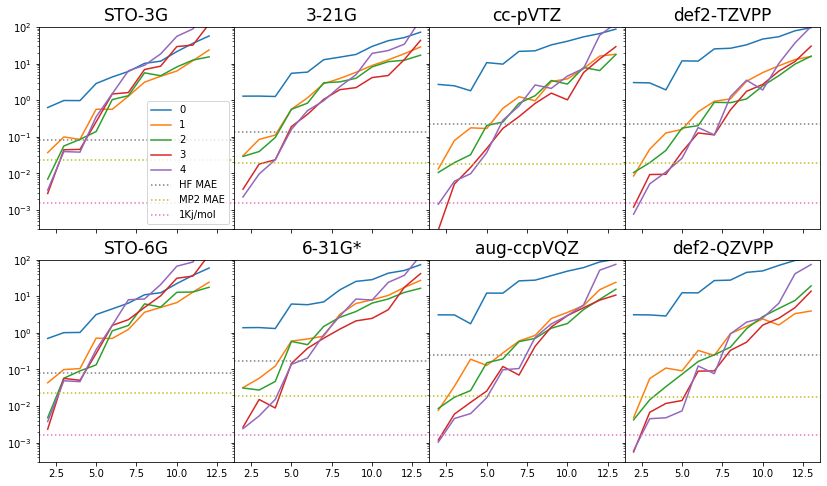

In [67]:
fig= plt.figure(figsize=(14,8))
axs = fig.subplots(2, 4,sharex=True, sharey=True)
plot(axs[0,0],dt_sto3g,"STO-3G")
plot(axs[1,0],dt_sto6g,"STO-6G")
plot(axs[0,1],dt_321g,"3-21G")
plot(axs[1,1],dt_631g,"6-31G*")
plot(axs[0,2],dt_ccpvtz,"cc-pVTZ")
plot(axs[1,2],dt_aug,"aug-ccpVQZ")
plot(axs[0,3],dt_tzvp,"def2-TZVPP")
plot(axs[1,3],dt_qzvpp,"def2-QZVPP")
plt.subplots_adjust(hspace=0.15,wspace=0)
axs[0,0].legend(loc=4)
plt.savefig("median_error.png")